# MIDTERM: PARAMETER ESTIMATION

# Questions

In this homework, you will do a parameter estimation for
BioModels model 45.

1. (10 pts) **Acquire the Model**. Create a roadrunner instance of the model and print the antimony representation of the model in an output cell.

1. (20 pts) **Data Generation**. Create synthetic data for the floating species using the values of the parameter in the published model:
   1. (10 pts) Create 3 sets of synthetic data for standard deviations of 0.1, 0.2, and 0.5.
   1. (10 pts) Plot the three datatsets. What characteristics of the data confirm that these synthetic data
   are consistent with your expectations.
   
1. (40 pts) **Experiment Infrastructure**. Implement the following functions:

    1. ``generateNoisyData``: Creates noisy versions of the simulation floating species. Inputs are antimony model and stadard deviation of noise; outputs are SBstoat.NamedTimeseries.
    1. ``doFit``: Encapsulates the fitting and evaluation workflow. Inputs are: antimony model, standard deviation of noise, the fitting method, and fractions of the true value for: lower end of parameter search, starting value of parameter search, and upper end of parameter search; Outputs are: residual sum of squares of the fit and the number of function evaluations (see ``getFitterInfo`` in Helper Functions).
    **Don't forget to document your functions and include tests. All tests must have at least one ``assert``**

   
1. (30 pts) **Experiments and Analysis**.
Use the experiment infrastructure to determine of effects of: standard deviation of noise,
search range, and search algorithm. You want to understand the impact on accuracy of parameter estimates and the time to do the parameter estimation. We will quantify accuracy in terms of residual sum of square, and time is in units of function evaluations.

    A. (20 pts) Plot the results. All experiments should set the starting value of the search
to the lower end of the range.
        1. Use the standard deviations of noise: 0.1, 0.2, 0.5
        1. Use the search ranges lower_frc, upper_frc = (0.5, 2.0) and (0.25, 4.0)
        1. Use the search algorithms ``leastsquares`` and ``differential_evolution``
   
   Construct plots as follows:
   
        1. x-axis: number of function evaluations
        2. y-axis: residual sum of squares
        3. Points are standard deviations, with separate lines for the two search algorithms.
    You will have 2 such plots.
    
   B. (10 pts) Explain the results.

**Please do your homework in a copy of this notebook, maintaining the sections.**

# Programming Preliminaries
This section provides the setup to run your python codes.

## Imports

In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SBstoat
import tellurium as te

## Constants

In [2]:
NUM_REPL = 3
STDS = [0, 0.1, 0.5]
# Key and column names
STD = "std"
RSSQ = "rssq"
NUM_EVAL = "num_eval"
METHOD = "method"
MAX_ERR = "max_err"
MEDIAN_ERR = "median_err"
REPL = "repl"
TS = "timeseries"

# Helper Functions

In [3]:
TEST_MODEL = """
A->B; A
B->; k*B; 
A = 10; 
B=0
k = 2
"""
TEST_MODEL_RR = te.loada(TEST_MODEL)
TEST_MODEL_ARR = TEST_MODEL_RR.simulate()
TEST_MODEL_TS = SBstoat.NamedTimeseries(array=TEST_MODEL_ARR, colnames=TEST_MODEL_ARR.colnames)

In [4]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index("time")
    return df

# Tests
assert(isinstance(arrToDF(TEST_MODEL_ARR), pd.DataFrame))
print("OK!")

OK!


In [18]:
def arrToTS(arr):
    """
    Converts NamedArray to a NamedTimeseries
    
    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    NamedTimeseries
    """
    return SBstoat.NamedTimeseries(array=arr, colnames=arr.colnames)

# Tests
assert(isinstance(arrToTS(TEST_MODEL_ARR), SBstoat.NamedTimeseries))
print("OK!")

OK!


In [5]:
def getParameterValueDct(model):
    """
    Finds the name and value of all parameters.
    
    Parameters
    ----------
    model: str (Antimony model)
    
    Returns
    -------
    dict (key: str, value: float)
    """
    rr = te.loada(model)
    return {n: rr[n] for n in rr.model.getGlobalParameterIds()}

# Tests
dct = getParameterValueDct(TEST_MODEL)
assert(isinstance(dct, dict))
assert("k" in dct.keys())
print("OK!")

OK!


In [6]:
FitterInfo = collections.namedtuple("FitterInfo", "rssq num_eval fitter max_err median_err")
def getFitterInfo(fitter):
    """
    Calculates statistics for the accuracy of a fit.
    
    Parameters
    ----------
    fitter: SBstoat.ModelFitter
    
    Returns
    -------
    FitterInfo
    """
    df = (fitter.residualsTS.to_dataframe()**2)
    rssq = df.sum().sum()
    # Find the number of function evaluations
    report_stg = fitter.reportFit()
    pos = report_stg.index("function evals")
    stg = report_stg[pos:]
    start_pos = stg.index("=") + 1
    end_pos = stg.index("\n")
    num_eval = int(stg[start_pos:end_pos])
    # Get statistics on the fit
    fitter.roadrunnerModel.resetAll()
    parameter_value_dct = getParameterValueDct(fitter.roadrunnerModel.getAntimony())
    errs = []
    for key, value in fitter.params.valuesdict().items():
        err = np.abs(value - parameter_value_dct[key])/parameter_value_dct[key]
        errs.append(err)
    max_err = max(errs)
    median_err = np.median(errs)
    #
    return FitterInfo(rssq=rssq, num_eval=num_eval, fitter=fitter, max_err=max_err, median_err=median_err)
    

# Tests
fitter = SBstoat.ModelFitter(TEST_MODEL, TEST_MODEL_TS, parametersToFit=[SBstoat.Parameter("k", lower=1, value=1, upper=4)])
fitter.fitModel()
fitter_info = getFitterInfo(fitter)
assert(np.isclose(fitter_info.rssq, 0))
assert(fitter_info.num_eval < 10)
print("OK!")

OK!


# Question 1: Acquire the model

In [7]:
MODEL_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000045.2?filename=BIOMD0000000045_url.xml")
MODEL_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000835.4?filename=Rao2014.xml")
MODEL_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000054.2?filename=BIOMD0000000054_url.xml")
MODEL_ARR = MODEL_RR.simulate()
MODEL_ANT = MODEL_RR.getAntimony()
print(MODEL_ANT)

// Created by libAntimony v2.13.2
function MTP(sf, V, Kms1, Kms2, Kms3, Kms4, Kms5, Kms7, Kms8, Kmp1, Kmp2, Kmp3, Kmp4, Kmp5, Kmp6, Kmp7, Kmp8, Ki1, Keq, S1, S2, S3, S4, S5, S7, S8, P1, P2, P3, P4, P5, P6, P7, P8, I1)
  sf*V*(S1*(S7 - P7)*S8/(Kms1*Kms7*Kms8) - P1*P7*P8/(Kms1*Kms7*Kms8*Keq))/((1 + S1/Kms1 + P1/Kmp1 + S2/Kms2 + P2/Kmp2 + S3/Kms3 + P3/Kmp3 + S4/Kms4 + P4/Kmp4 + S5/Kms5 + P5/Kmp5 + P6/Kmp6 + I1/Ki1)*(1 + (S7 - P7)/Kms7 + P7/Kmp7)*(1 + S8/Kms8 + P8/Kmp8));
end

MTP is "MTP_2"

function MCKATB(sf, V, Kms1, Kms2, Kms3, Kms4, Kms5, Kms6, Kms7, Kms8, Kmp1, Kmp2, Kmp3, Kmp4, Kmp5, Kmp6, Kmp7, Kmp8, Keq, S1, S2, S3, S4, S5, S6, S7, S8, P1, P2, P3, P4, P5, P6, P7, P8)
  sf*V*(S1*S8/(Kms1*Kms8) - P8*P8/(Kms1*Kms8*Keq))/((1 + S1/Kms1 + P1/Kmp1 + S2/Kms2 + P2/Kmp2 + S3/Kms3 + P3/Kmp3 + S4/Kms4 + P4/Kmp4 + S5/Kms5 + P5/Kmp5 + S6/Kms6 + P6/Kmp6 + S7/Kms7 + P7/Kmp7 + P8/Kmp8)*(1 + S8/Kms8 + P8/Kmp8));
end

MCKATB is "MCKATB_2"

function RES(Ks, S, K1)
  Ks*(S - K1);
end

RES is "RES_2"


In [8]:
PARAMETER_DCT = getParameterValueDct(MODEL_ANT)
len(PARAMETER_DCT)

202

# Question 2: Data Generation

In [9]:
def generateNoisyData(std, model=MODEL_ANT, is_plot=True):
    """
    Generates noise columns in a dataframe.
    
    Parameters
    ----------
    std: float (standard deviation of generated noise)
    model: str (antimony model)
    is_plot: bool (plot the noise)
    
    Returns
    -------
    NamedTimeseries
    """
    rr = te.loada(model)
    data = rr.simulate()
    df = arrToDF(data)
    normalization_ser = df.mean()
    # Use the input DataFrame as a template
    noise_df = df.copy()
    # Create the noise data
    for column in noise_df.columns:
        noise_arr = np.random.normal(0, std, len(noise_df))
        noise_df[column] = normalization_ser.loc[column]*noise_arr
    data_df = df + noise_df
    if is_plot:
        _, ax = plt.subplots(1)
        for column in data_df.columns:
            ax.scatter(data_df.index, data_df[column])
        plt.legend(noise_df.columns)
        plt.title("Generated Noise. Std=%2.2f" % std)
    return SBstoat.NamedTimeseries(dataframe=data_df)
                  
# Tests
df = generateNoisyData(0, is_plot=False)
assert(isinstance(df, SBstoat.NamedTimeseries))
print("OK!")

OK!


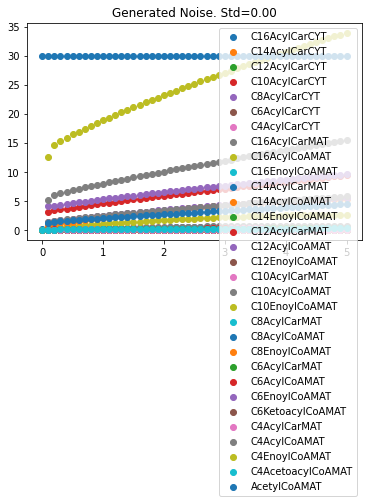

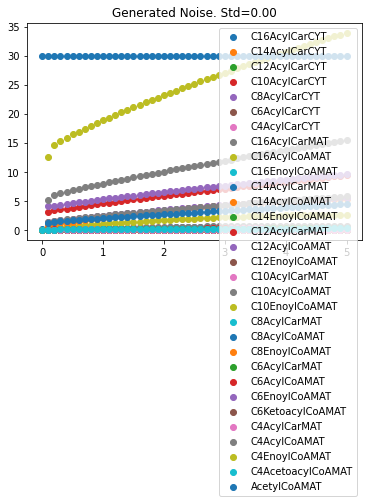

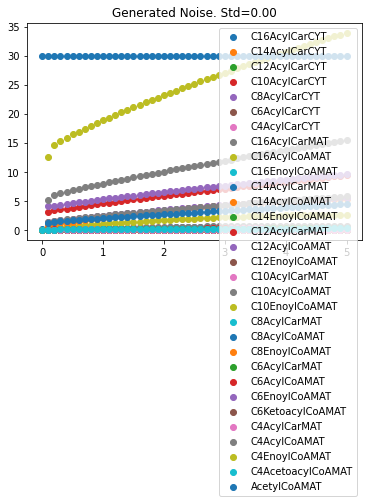

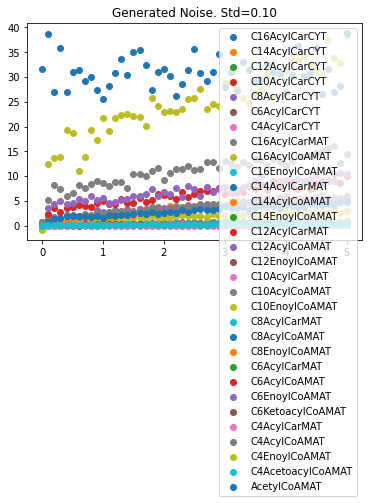

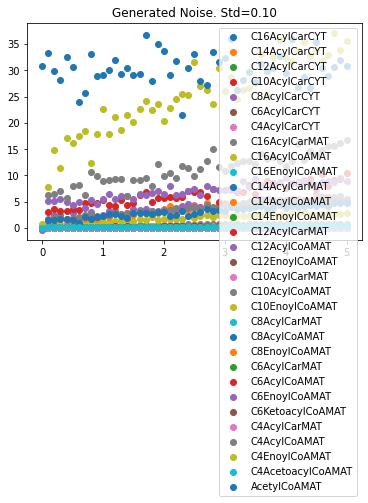

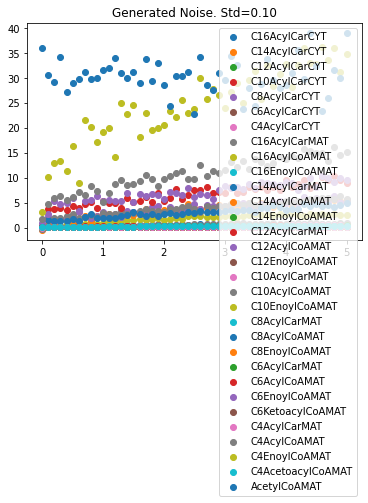

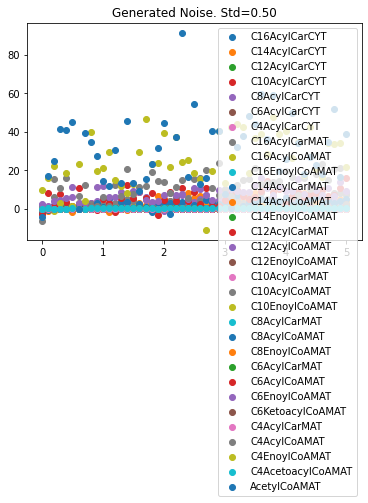

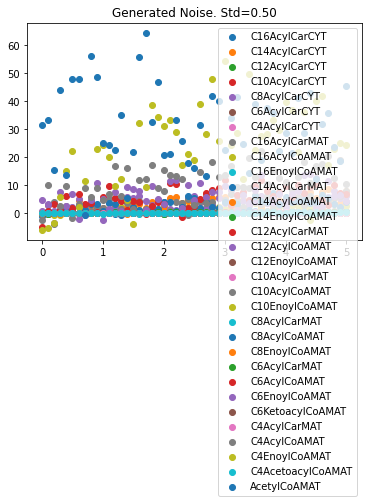

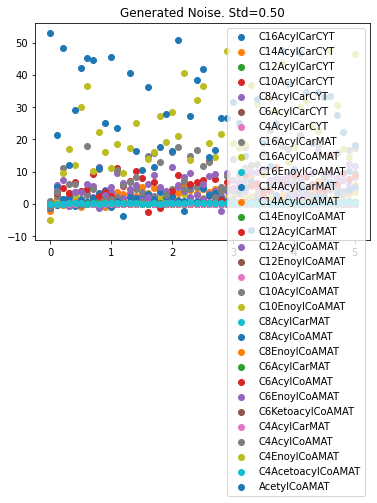

In [10]:
DATA_DCT = {STD: [], TS: []}
for std in STDS:
    for repl in range(NUM_REPL):
        DATA_DCT[STD].append(std)
        DATA_DCT[TS].append(generateNoisyData(std))

# Question 3: Experiment Infrastructure

In [11]:
# Dictionary representation of the parameters and their values
def getParameters(parameter_value_dct, lower_frc=1.0, value_frc=1.0, upper_frc=1.0):
    """
    Constructs the list of parameters for for the model.
    
    Parameters
    ----------
    parameter_value_dct: dict (key: name, value: parameter value)
    lower_frc: float (fraction used to calculate lower range of search. Should be in [0, 1.0])
    value_frc: float (fraction used to calculate start of search. lower_frc <= value_frc <= upper_frc)
    upper_frc: float (fraction used to calculate upper limit of search. Should be in [value_frc, inf])
    
    Returns
    -------
    list-SBstoat.Parameter
    """
    parameters = []
    for key, true_value in parameter_value_dct.items():
        lower = lower_frc*true_value
        value = value_frc*true_value
        upper = upper_frc*true_value
        parameter = SBstoat.Parameter(key, lower=lower, value=value, upper=upper)
        parameters.append(parameter)
        # Calculate median
    return parameters

# Tests
parameter_value_dct = {"k1": 1, "k2": 2}
parameters = getParameters(parameter_value_dct, lower_frc=0.5, value_frc=0.8, upper_frc=2.0)
assert(len(parameters) == 2)
assert(isinstance(parameters[0], SBstoat.Parameter))
assert(parameters[0].lower == 0.5)
assert(parameters[0].value == 0.8)
assert(parameters[0].upper == 2.0)
print("OK!")

OK!


In [12]:
def doFit(observed_ts, model=MODEL_ANT,
          fitter_methods=["leastsq"], 
          lower_frc=0.5,
          value_frc=0.5,
          upper_frc=2.0,
          is_report=False):
    """
    Encapsulates the workflow to fit the linear pathway model and return appropirate statistics.

    Parameters
    ----------
    model: str (Antimony model)
    observed_ts: NamedTimeseries (synthetic data)
    fitter_method: str ("leastsquares" or "differential_evolution")
    lower_frc, value_frc, upper_frc: scaling of range for parameters
    is_report: bool
        Produce outputs

    Returns
    -------
    FitterInfo
    """
    parameter_value_dct = getParameterValueDct(model)
    parameters = getParameters(parameter_value_dct, lower_frc=lower_frc, value_frc=value_frc, upper_frc=upper_frc)
    # Construct the fitter and do the fit
    fitter = SBstoat.ModelFitter(model, observed_ts,
                         fitterMethods=fitter_methods, 
                         parametersToFit=parameters)
    fitter.fitModel()
    if is_report:
        print(fitter.reportFit())
        fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"],
                          titlePosition=(0.5, 1.05))
    return getFitterInfo(fitter)

# TESTS
fitter_info = doFit(DATA_DCT[TS][0], fitter_methods=["leastsquares"],
              lower_frc=0.5, value_frc=0.5, upper_frc=2.0, is_report=False)
assert(fitter_info.rssq > 1)
assert(fitter_info.num_eval > 0)
print("OK")

OK


# Question 4: Experiment Execution and Analysis

OK!


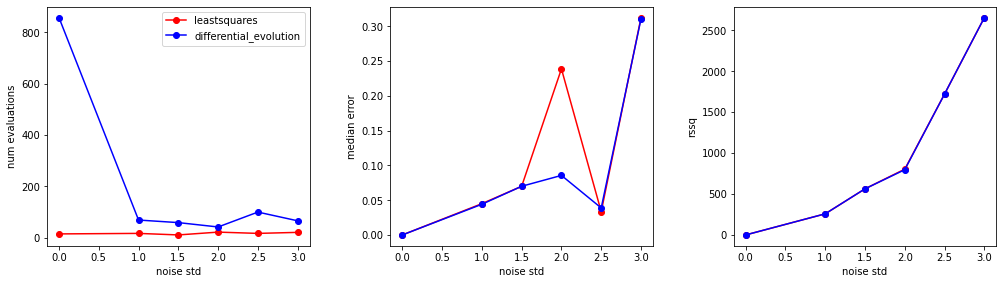

In [71]:
def makePlot(model=MODEL_ANT, search_range=2, data_dct=DATA_DCT, is_plot=True):
    """
    Creates a results plot for the specified parameters.
    
    Parameters
    ----------
    model: str (antimony model)
    search_range: float (size of the search range for the fit)
    data_dct: dict (keys: STD (standard deviation), TS (timeseries))
    
    Returns
    -------
    DataFrame: columns
        std: standard deviation of data
        rssq: residual sum of squares of fit
        num_eval: number of evaluations
        method: optimization algorithm
        max_err: maximum fitting error for the parameters
        median_err: median fitting error
    """
    # Initializations
    lower_frc = 1/search_range
    value_frc = lower_frc
    upper_frc = search_range
    METHODS =  ["leastsquares", "differential_evolution"]
    # Obtain the fitter results
    result_dct = {n: [] for n in [STD, RSSQ, NUM_EVAL, METHOD, MAX_ERR, MEDIAN_ERR]}
    for method in METHODS:
        for std, ts in zip(data_dct[STD], data_dct[TS]):
            fitter_info = doFit(ts, model=model, fitter_methods=[method], lower_frc=lower_frc,
                  value_frc=value_frc, upper_frc=upper_frc, is_report=False)
            result_dct[STD].append(std)
            result_dct[METHOD].append(method)
            result_dct[RSSQ].append(fitter_info.rssq)
            result_dct[NUM_EVAL].append(fitter_info.num_eval)
            result_dct[MAX_ERR].append(fitter_info.max_err)
            result_dct[MEDIAN_ERR].append(fitter_info.median_err)
    result_df = pd.DataFrame(result_dct)
    # Construct plot
    if is_plot:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.tight_layout(pad=5.0)
        colors = ["red", "blue"]
        for idx, method in enumerate(METHODS):
            plot_df = result_df[result_df[METHOD] == method]
            axes[0].plot(plot_df[STD], plot_df[NUM_EVAL], color=colors[idx], marker="o")
            axes[1].plot(plot_df[STD], plot_df[MEDIAN_ERR], color=colors[idx], marker="o")
            axes[2].plot(plot_df[STD], plot_df[RSSQ], color=colors[idx], marker="o")
    #
    axes[0].set_ylabel("num evaluations")
    axes[1].set_ylabel("median error")
    axes[2].set_ylabel("rssq")
    axes[0].legend(METHODS, loc="upper right")
    for ax in axes:
        ax.set_xlabel("noise std")
    return result_df

# Tests
stds = [0, 1, 1.5, 2, 2.5, 3]
data_dct = {STD: [], TS: []}
for std in stds:
    data_dct[STD].append(std)
    data_dct[TS].append(generateNoisyData(std, model=TEST_MODEL, is_plot=False))
result_df = makePlot(model=TEST_MODEL, search_range=2, data_dct=data_dct, is_plot=True)
diff = set(result_df.columns).symmetric_difference([STD, RSSQ, NUM_EVAL, METHOD, MAX_ERR, MEDIAN_ERR])
assert(len(diff) == 0)
print("OK!")

Analysis of the model